# GOAL: Build and train a regression model(s) that predicts the number of rented bikes

# Get Data

In [4]:
import pandas as pd
import numpy as np

import matplotlib.pyplot as plt
import seaborn as sns

from sklearn.linear_model import Lasso, Ridge, ElasticNet, LinearRegression, PoissonRegressor
from sklearn.model_selection import train_test_split, GridSearchCV
from sklearn.compose import ColumnTransformer, TransformedTargetRegressor
from sklearn.pipeline import Pipeline, make_pipeline
from sklearn.preprocessing import FunctionTransformer, MinMaxScaler, OneHotEncoder, PolynomialFeatures
from sklearn.impute import SimpleImputer 
from sklearn import metrics
from sklearn.metrics import mean_squared_error, r2_score, mean_squared_log_error, mean_absolute_error
from sklearn.feature_selection import RFE

sns.set() 
sns.set_style("whitegrid")

%matplotlib inline

# Set figure size to (10,7)
#plt.rcParams['figure.figsize'] = (10,7)
#sns.set() 
#sns.set_style("whitegrid")

In [5]:
main_df = pd.read_csv('/home/elendar/spicy/binomial-baharat-encounter-notes/week03/data/train.csv',parse_dates=['datetime']) #, parse_dates=True, index_col=0
#bike_shop.set_index('datetime')
bike_shop=main_df

In [6]:
bike_shop = bike_shop.loc[bike_shop['weather'] != 4]    # There is only one entry with weather=4 which would make big problems, when it test-valid split. Therefore
                                                        # get rid of it asap

In [7]:
df=bike_shop
#df=bike_shop['2011-01-01 00:00:00':'2012-01-02 00:00:00']
print(df.shape)
df.head(1)

(10885, 12)


,datetime,season,holiday,workingday,weather,temp,atemp,humidity,windspeed,casual,registered,count
0,2011-01-01,1,0,0,1,9.84,14.395,81,0.0,3,13,16


# TRAIN-VALIDATION SPLIT

In [9]:
X = df.drop(columns=['count'])
y = df['count']
X.head(1)
Xtrain, Xval, ytrain, yval = train_test_split(X, y, train_size=0.75, random_state=25)
X.shape, y.shape
#Xtrain.mean()

((10885, 11), (10885,))

# 1st Feature Engineering

In [51]:
Xtrain.head(1)

,datetime,season,holiday,workingday,weather,temp,atemp,humidity,windspeed,casual,registered
5728,2012-01-13 20:00:00,1,0,1,1,9.84,12.12,41,11.0014,6,130


In [52]:
ytrain.head(1)

5728    136
Name: count, dtype: int64

In [53]:
# Season, rush-hour, weather, year should be catologized (with kind of increasing importance)
# Holiday, workingday already categorized
# hour, atemp, humidity, user_ratio, windspeed (with increasing importance, windspeed is close to negligible) 

In [54]:
def treat_time(df_date):
    df_date["year"]      =df_date["datetime"].dt.year
    df_date["month"]     =df_date["datetime"].dt.month
    df_date["day"]       =df_date["datetime"].dt.day
    #df_date["weekday"]   =df_date["datetime"].dt.weekday
    df_date["hour"]      =df_date["datetime"].dt.hour
    return df_date


In [55]:
Xtrain = treat_time(Xtrain)
Xtrain = Xtrain.drop(columns=['registered', 'casual', 'temp'])
Xval = treat_time(Xval)

In [56]:
# creating a dataframe of Xtrain and ytrain for the exploratory data analysis
train_df = pd.concat([Xtrain, ytrain], axis=1)


In [57]:
#ytrain = treat_time(ytrain)

# Exploratory Data Analysis (EDA) (Make it 'Markdown' to see the graphs)

<AxesSubplot:ylabel='Frequency'>

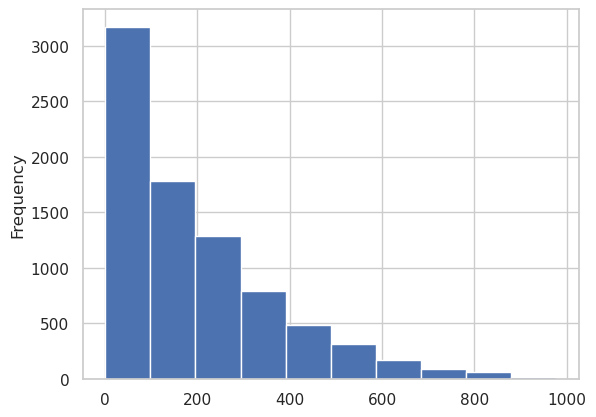

In [13]:
train_df["count"].plot.hist()

In [14]:
print(train_df.info())
train_df.head(1)

<class 'pandas.core.frame.DataFrame'>
Int64Index: 8163 entries, 5728 to 8511
Data columns (total 13 columns):
 #   Column      Non-Null Count  Dtype         
---  ------      --------------  -----         
 0   datetime    8163 non-null   datetime64[ns]
 1   season      8163 non-null   int64         
 2   holiday     8163 non-null   int64         
 3   workingday  8163 non-null   int64         
 4   weather     8163 non-null   int64         
 5   atemp       8163 non-null   float64       
 6   humidity    8163 non-null   int64         
 7   windspeed   8163 non-null   float64       
 8   year        8163 non-null   int64         
 9   month       8163 non-null   int64         
 10  day         8163 non-null   int64         
 11  hour        8163 non-null   int64         
 12  count       8163 non-null   int64         
dtypes: datetime64[ns](1), float64(2), int64(10)
memory usage: 892.8 KB
None


,datetime,season,holiday,workingday,weather,atemp,humidity,windspeed,year,month,day,hour,count
5728,2012-01-13 20:00:00,1,0,1,1,12.12,41,11.0014,2012,1,13,20,136


<AxesSubplot:xlabel='atemp', ylabel='count'>

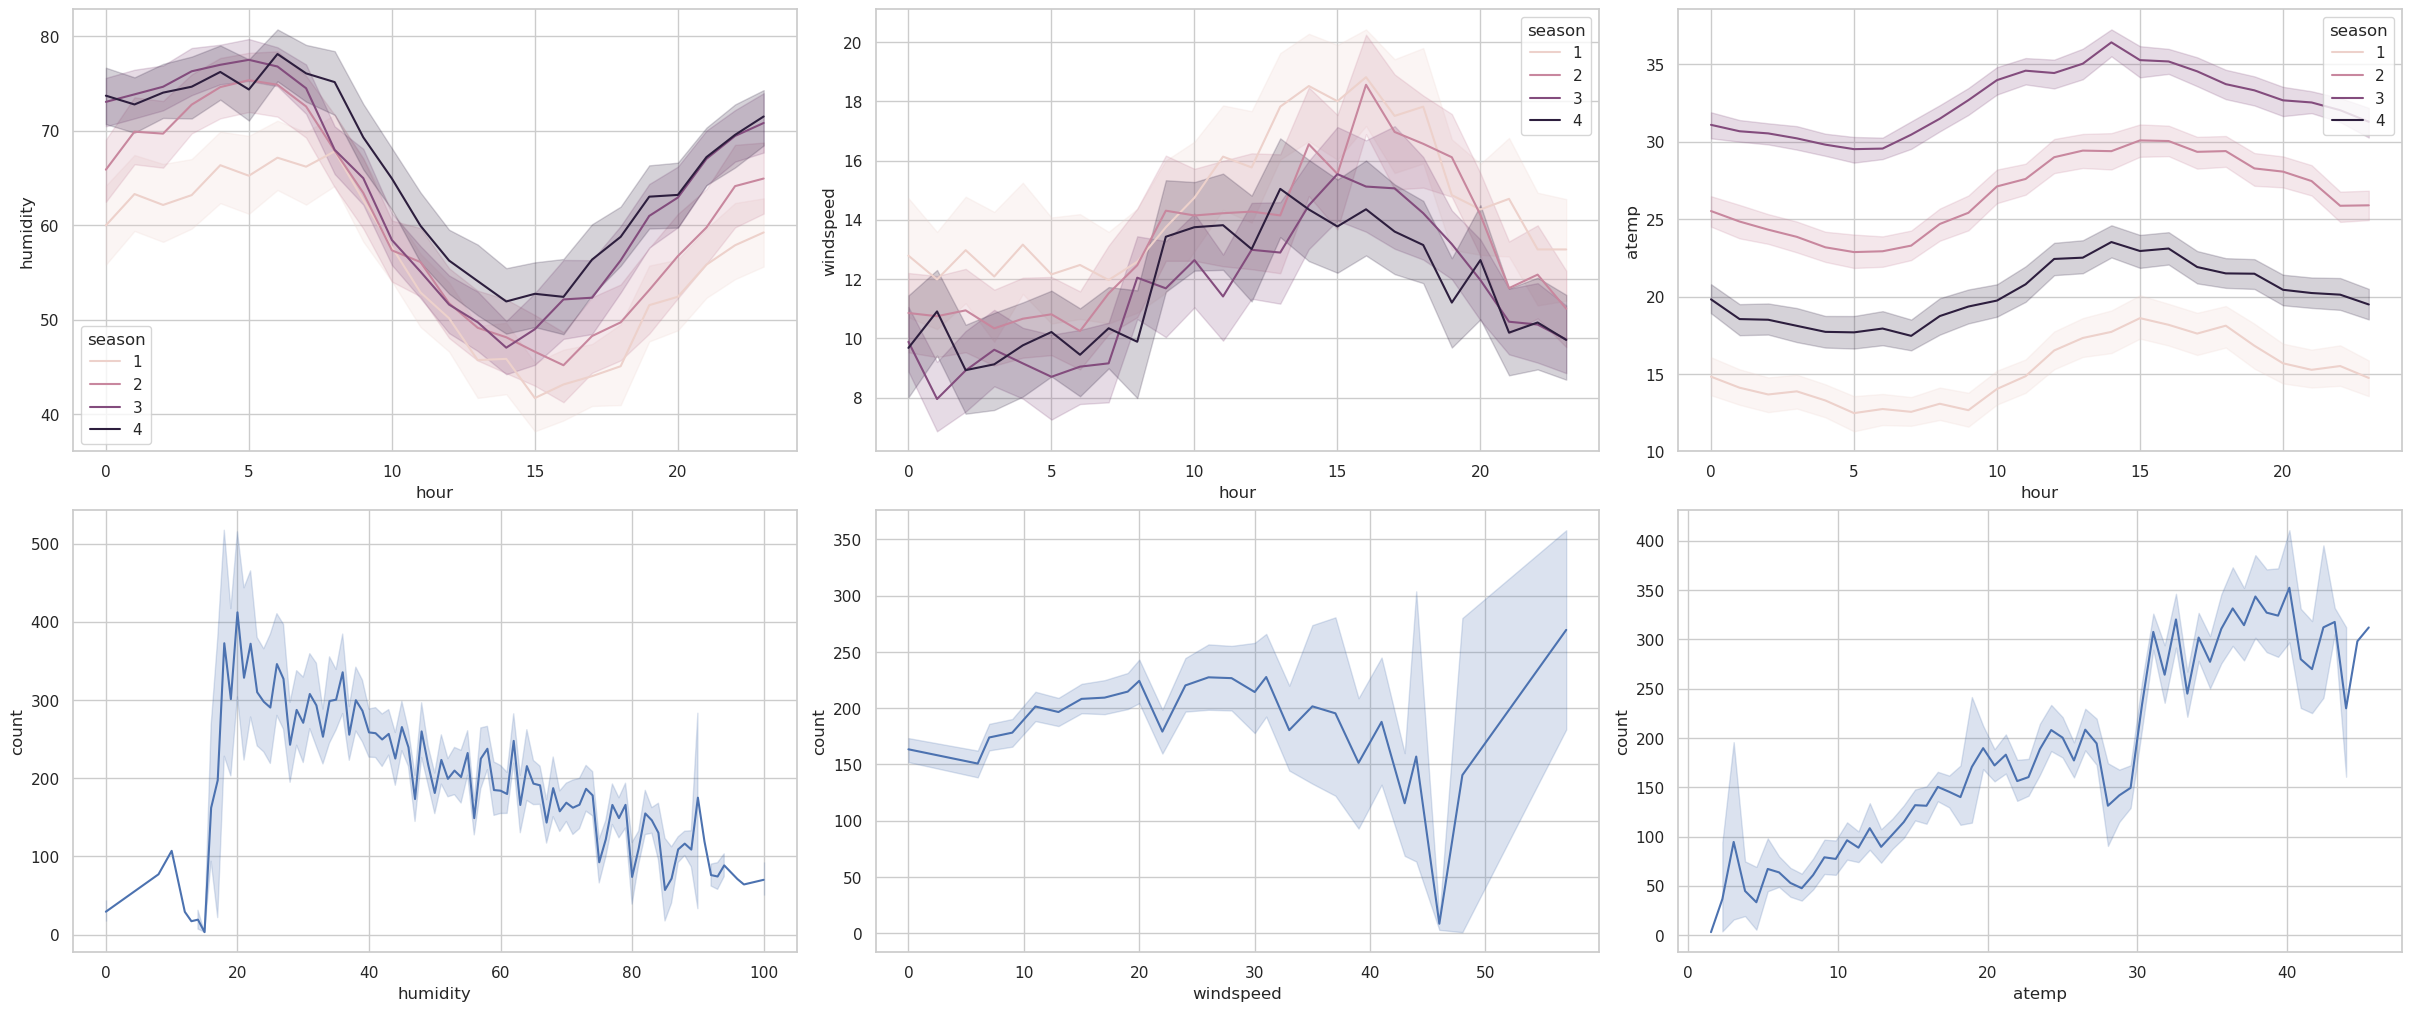

In [15]:
fig, axs = plt.subplots(ncols=3, nrows=2, figsize=(24, 10), 
                        layout="constrained")

sns.lineplot(data=train_df, x="hour", y="humidity", hue='season', ax=axs[0,0])
sns.lineplot(data=train_df, x="hour", y="windspeed", hue='season', ax=axs[0,1])
sns.lineplot(data=train_df, x="hour", y="atemp", hue='season', ax=axs[0,2])

sns.lineplot(data=train_df, x="humidity", y="count", ax=axs[1,0])
sns.lineplot(data=train_df, x="windspeed", y="count", ax=axs[1,1])
sns.lineplot(data=train_df, x="atemp", y="count", ax=axs[1,2])

<AxesSubplot:xlabel='humidity', ylabel='windspeed'>

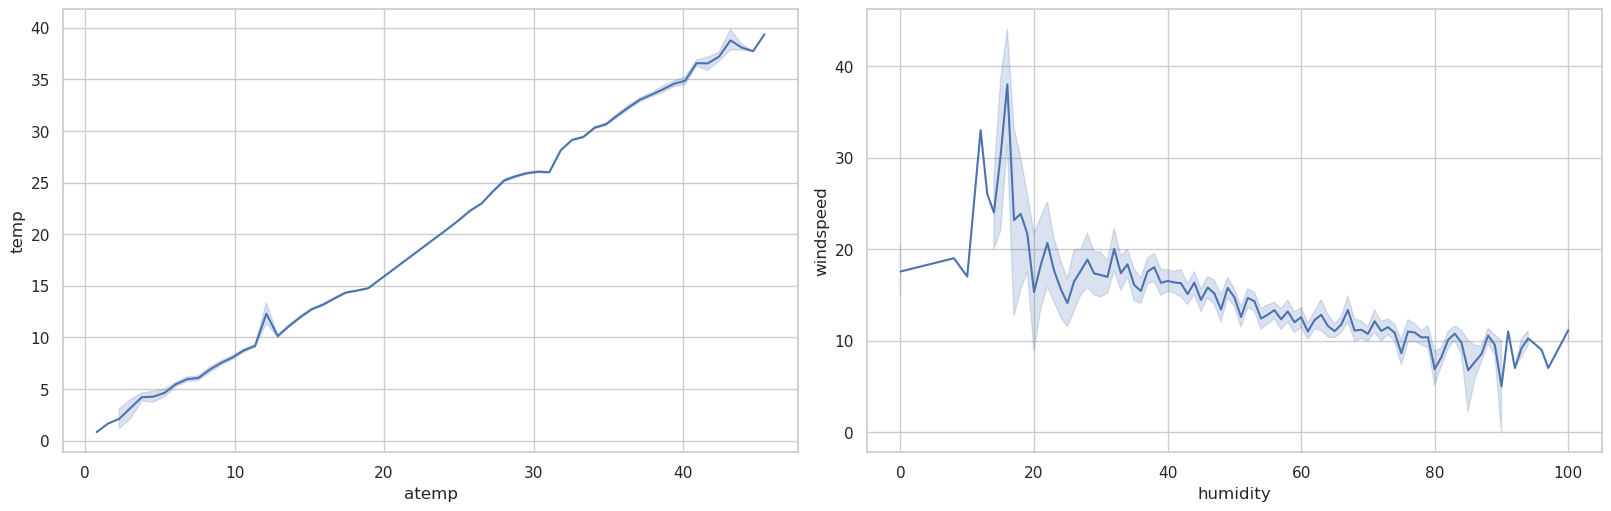

In [16]:
fig, axs = plt.subplots(ncols=2, nrows=1, figsize=(16, 5), 
                        layout="constrained")
sns.lineplot(data=df, x="atemp", y="temp", ax=axs[0])
#sns.lineplot(data=df, x="atemp", y="user_ratio", hue='workingday', ax=axs[0,1])
#sns.lineplot(data=df, x="user_ratio", y="count", hue='workingday',ax=axs[0,2])

#sns.lineplot(data=df, x="user_ratio", y="count", ax=axs[1,0])
sns.lineplot(data=df, x="humidity", y="windspeed", ax=axs[1])

<AxesSubplot:xlabel='month', ylabel='count'>

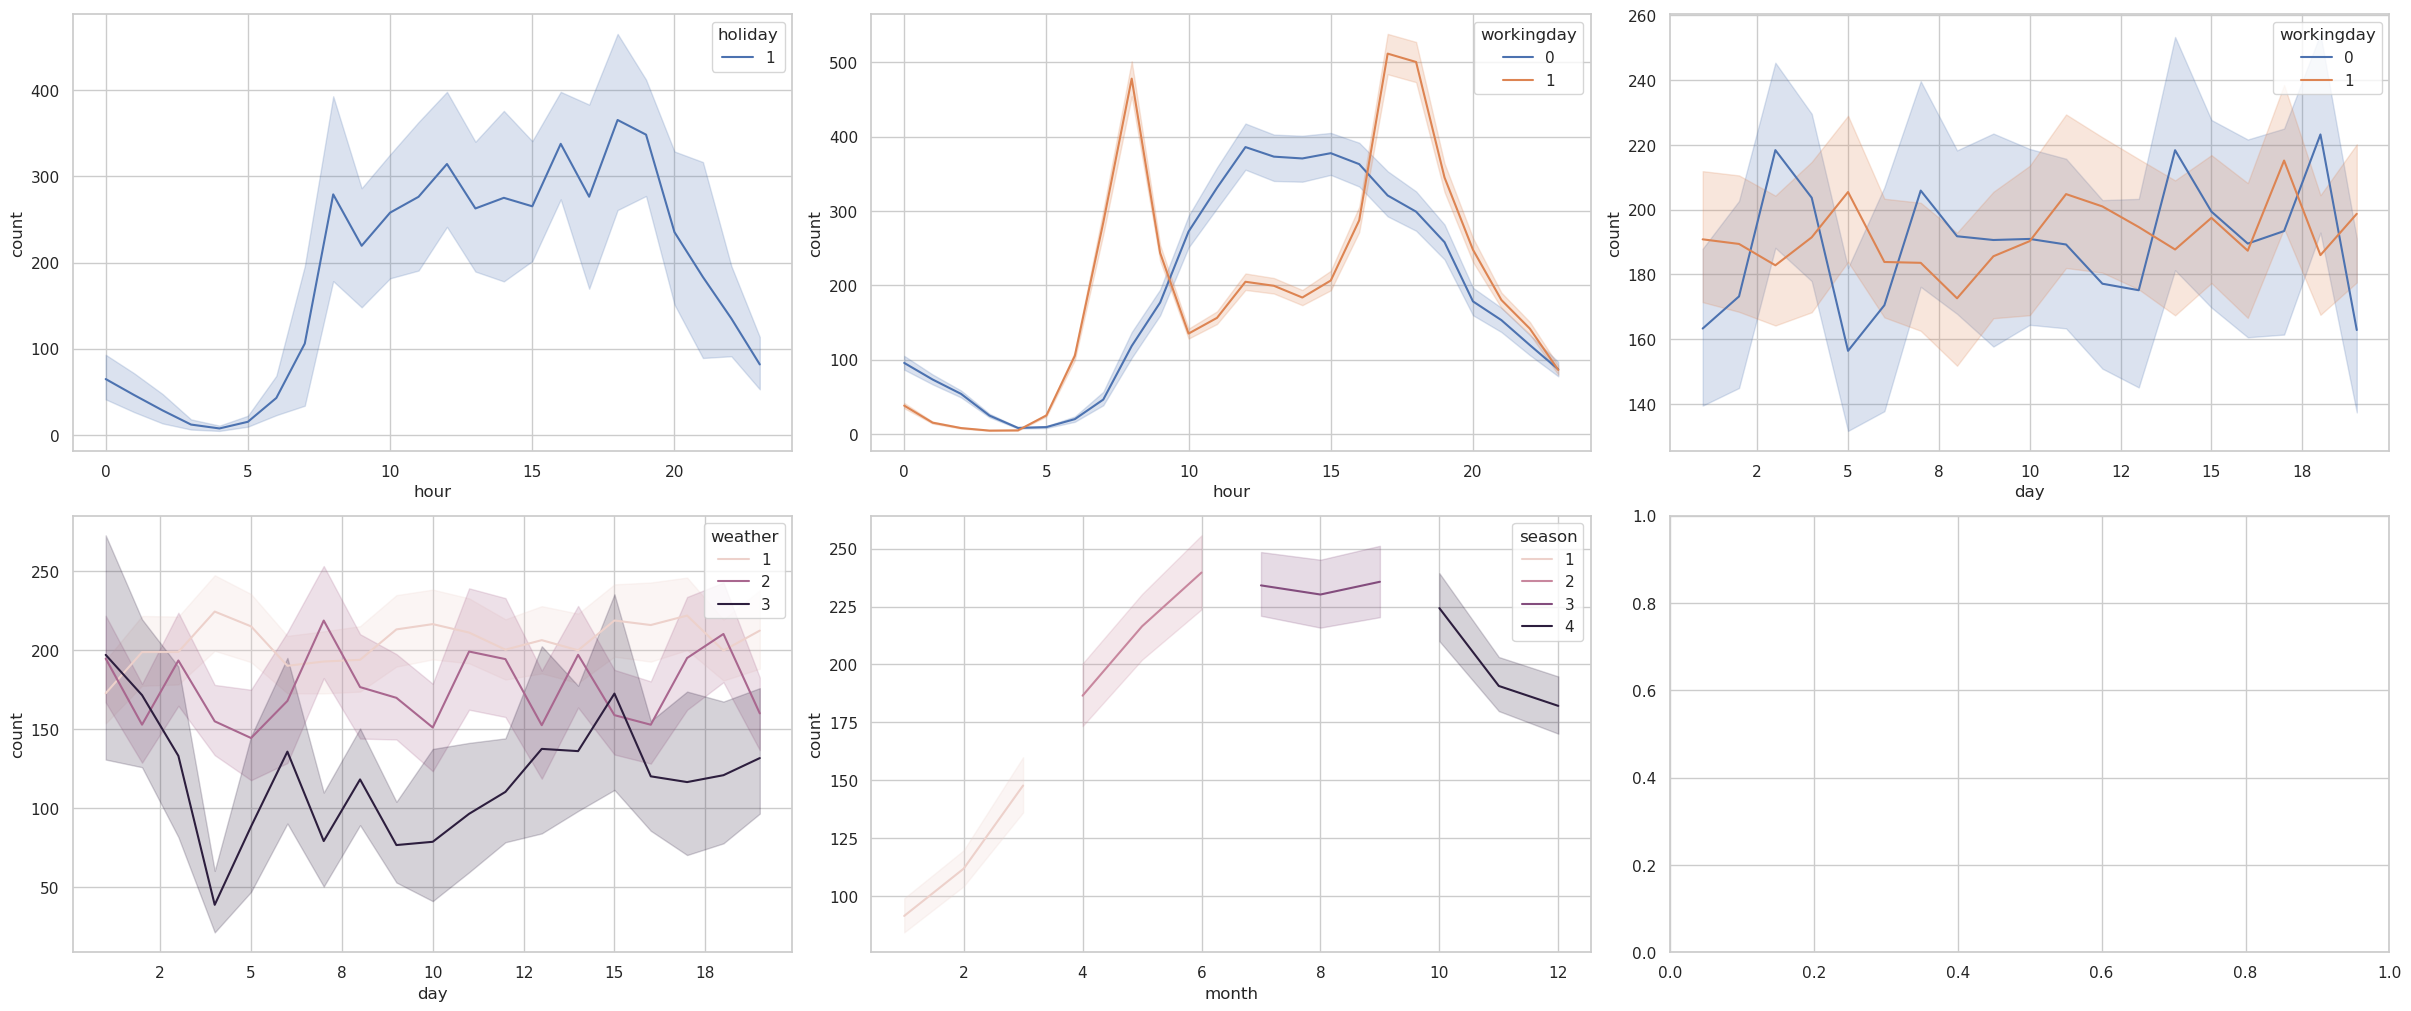

In [17]:

fig, axs = plt.subplots(ncols=3, nrows=2, figsize=(24, 10), 
                        layout="constrained")

sns.lineplot(data=train_df.loc[train_df['holiday'] == 1], x="hour", y="count", hue="holiday", ax=axs[0,0])
sns.lineplot(data=train_df, x="hour", y="count", hue="workingday", ax=axs[0,1])
sns.lineplot(data=train_df, x="day", y="count", hue="workingday", ax=axs[0,2])
axs[0,2].xaxis.set_major_formatter('{x:.0f}')

sns.lineplot(data=train_df, x="day", y="count", hue="weather", ax=axs[1,0])
axs[1,0].xaxis.set_major_formatter('{x:.0f}')
sns.lineplot(data=train_df, x="month", y="count", hue="season", ax=axs[1,1])






<AxesSubplot:xlabel='year', ylabel='atemp'>

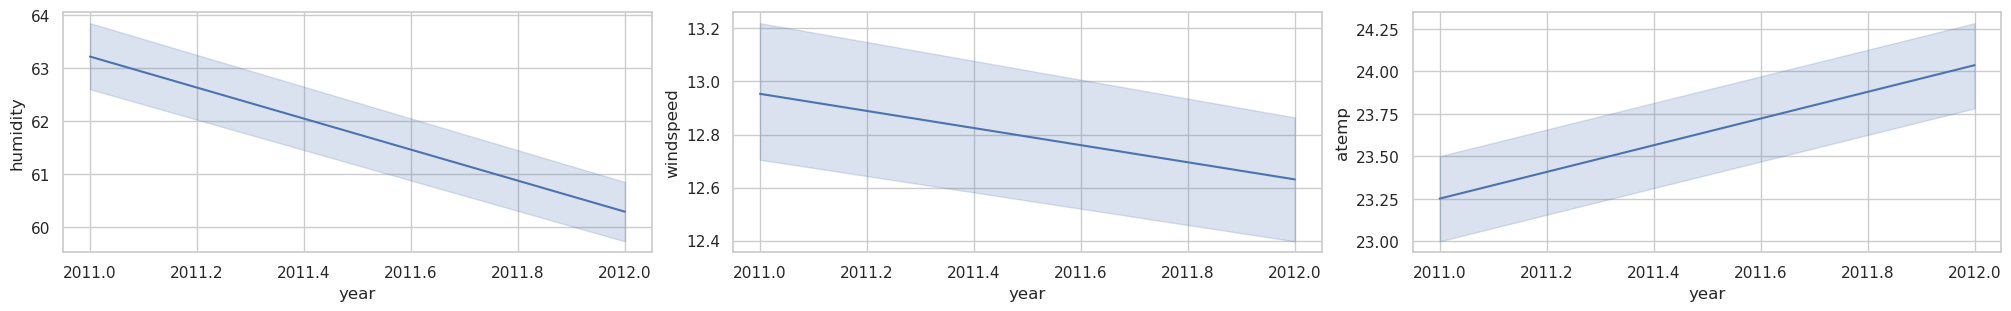

In [18]:
fig, axs = plt.subplots(ncols=3, nrows=1, figsize=(20, 3), 
                        layout="constrained")
sns.lineplot(data=train_df, x="year", y="humidity", ax=axs[0])
sns.lineplot(data=train_df, x="year", y="windspeed", ax=axs[1])
sns.lineplot(data=train_df, x="year", y="atemp", ax=axs[2])

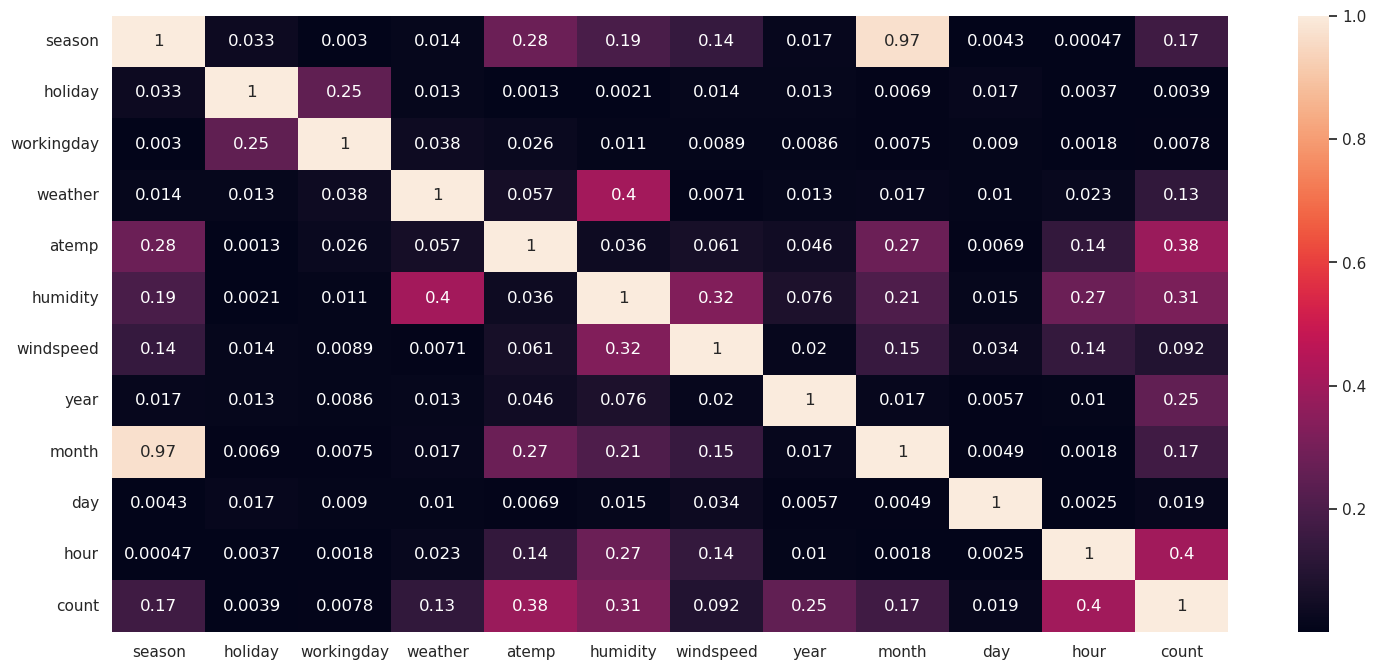

In [19]:
plt.figure(figsize=(18,8))
sns.heatmap(train_df.corr().abs(), annot=True) #numeric_only=True
plt.show()



In [20]:
sns.pairplot(train_df[['holiday', 'workingday', 'weather', 'atemp', 'humidity', 'windspeed', 'month', 'hour', 'count']], hue="workingday")

KeyboardInterrupt: 

Error in callback <function flush_figures at 0x7fd4f53adb80> (for post_execute):


KeyboardInterrupt: 

In [ ]:
fig, axs = plt.subplots(ncols=2, nrows=1, figsize=(12, 8),
                        layout="constrained")
sns.boxplot(data=train_df, x='weather', y='count', color="red", hue="workingday", ax=axs[0])
sns.boxplot(data=train_df, x='holiday', y='count', hue="workingday", ax=axs[1])

# Feature Engineering

In [58]:
cat_pipe = make_pipeline(SimpleImputer(strategy='most_frequent'),
                         (OneHotEncoder(handle_unknown='ignore', sparse=False)),
                         MinMaxScaler()
)

In [59]:
num_pipe = make_pipeline(SimpleImputer(strategy='median'),
                         MinMaxScaler()
)

In [64]:
feature_transform = ColumnTransformer(
    transformers=[
        #("treat_time", FunctionTransformer(treat_time), "datetime"),
        #("treat_new", FunctionTransformer(treat_new), ["registered",'casual']), #, "workingday","hour"                            
        ("num", num_pipe, ['hour', 'atemp', 'humidity', 'windspeed']), #'user_ratio', 
        ("cat", cat_pipe, ['season', 'weather', 'year', 'month']), #'rush_hour',     
        ("do_nothing", 'passthrough', ['holiday','workingday'])],
        remainder='drop'
)

# Modelling

In [91]:
lasso_pipe = Pipeline(
    steps=[("features",feature_transform),
           #("poly", poly_pipe),
           ("poly",PolynomialFeatures(include_bias=False, degree=2)),
           #('model', TransformedTargetRegressor(regressor=LinearRegression(),
           #                              func=np.log1p, inverse_func=np.expm1))
           ("lassomodel",Lasso(positive=True, max_iter=10000))
])
#TransformedTargetRegressor(regressor=LinearRegression(), func=np.log1p, inverse_func=np.expm1))])
#Lasso(positive=True, max_iter=10000)

#lasso = Lasso()
#ridge = Ridge()
#elast = ElasticNet()
lasso_pipe

Pipeline(steps=[('features',
                 ColumnTransformer(transformers=[('num',
                                                  Pipeline(steps=[('simpleimputer',
                                                                   SimpleImputer(strategy='median')),
                                                                  ('minmaxscaler',
                                                                   MinMaxScaler())]),
                                                  ['hour', 'atemp', 'humidity',
                                                   'windspeed']),
                                                 ('cat',
                                                  Pipeline(steps=[('simpleimputer',
                                                                   SimpleImputer(strategy='most_frequent')),
                                                                  ('onehotencoder',
                                                                   OneHotEncoder(handle_unknown='ignore',
                                                                                 sparse=False)),
                                                                  ('minmaxscaler',
                                                                   MinMaxScaler())]),
                                                  ['season', 'weather', 'year',
                                                   'month']),
                                                 ('do_nothing', 'passthrough',
                                                  ['holiday', 'workingday'])])),
                ('poly', PolynomialFeatures(include_bias=False)),
                ('lassomodel', Lasso(max_iter=10000, positive=True))])

In [92]:
lasso_pipe.fit(Xtrain,ytrain)
lasso_pipe.score(Xtrain, ytrain)

0.3896124106148243

@channel "What if I predict negative values?
If some of you have already run into the issue where your model is predicting negative values for some data points, this is completely normal! Why does this happen? Well, linear models are unbounded (-:infinity: <-> +:infinity:) and so it's technically possible that values can extrapolate beyond zero in the prediction after applying the solved coefficients & intercept. Of course, from a business context though, this makes no sense: We cannot have negative bicycles predicted. Here are 3 strategies on how to get around this: 
1.Simply replace the negative predicted values with something else (e.g. zero). e,g: y_pred[y_pred < 0] = 0.0 Scale / transform the target column (bicycle count). 
2.Predict the log of count, for example: m.fit(Xtrain, np.log(ytrain)). Of course, then do not forget to "un-log" (i.e. np.exp()) the prediction afterwards, otherwise your model is reporting the log of the demand, which is on a different scale. 
3.Alternatively, use np.log1p() and its inverse, np.expm1(). Use a non-linear model that doesn't extrapolate into the negative value problem, e.g. the RandomForestRegressor 

Bonus: Try out the 3-star challenge in the Feature Expansion section of the course material with the PoissonRegressor, which is basically a way to do option 2 without manually transforming the data yourself"

In [93]:
print(f'RMSLE train: {mean_squared_log_error(ytrain,lasso_pipe.predict(Xtrain),squared=False)}')
print(f'RMSLE test: {mean_squared_log_error(yval,lasso_pipe.predict(Xval),squared=False)}')
print(f'R2 train: {r2_score(ytrain,lasso_pipe.predict(Xtrain))}')
print(f'R2 test: {r2_score(yval,lasso_pipe.predict(Xval))}')
print(f'Score train: {lasso_pipe.score(Xtrain,ytrain)}')
print(f'Score test: {lasso_pipe.score(Xval,yval)}')

ValueError: Mean Squared Logarithmic Error cannot be used when targets contain negative values.

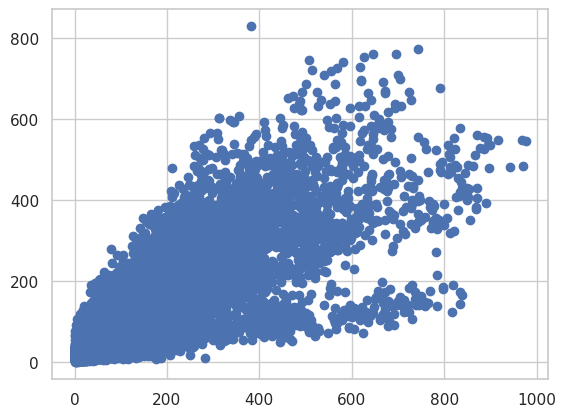

In [83]:
ypred=lasso_pipe.predict(Xtrain)
plt.scatter(ytrain,ypred)

# Hyperparameter Optimization

In [ ]:
lasso_pipe.get_params();

In [84]:
parameter_grid = {
    'poly__degree': [2,3]#,
    #'lassomodel__alpha': [0.1]
}

In [85]:
gridsearch = GridSearchCV(lasso_pipe, 
                          parameter_grid, 
                          scoring=None,    #return
                          verbose=1,       #how talkitive, give more detailed report
                          cv=3             #cross-validation
                        )
#Be careful with the selection of of the parameters for the gridsearch as it could take hours to run.
#In this case I have 3 degrees, 3 alphas and 5 cross validations. This makes 9 different combinations which run 5 times.
#Decreasing alpha more than 0.1 and increasing the degree more than 3 increases the time of the fitting drastically


In [86]:
gridsearch.fit(Xtrain,ytrain)

Fitting 3 folds for each of 2 candidates, totalling 6 fits


/home/elendar/anaconda3/lib/python3.9/site-packages/sklearn/preprocessing/_function_transformer.py:292: RuntimeWarning: overflow encountered in expm1
  return func(X, **(kw_args if kw_args else {}))
/home/elendar/anaconda3/lib/python3.9/site-packages/sklearn/model_selection/_validation.py:776: UserWarning: Scoring failed. The score on this train-test partition for these parameters will be set to nan. Details: 
Traceback (most recent call last):
  File "/home/elendar/anaconda3/lib/python3.9/site-packages/sklearn/model_selection/_validation.py", line 767, in _score
    scores = scorer(estimator, X_test, y_test)
  File "/home/elendar/anaconda3/lib/python3.9/site-packages/sklearn/metrics/_scorer.py", line 429, in _passthrough_scorer
    return estimator.score(*args, **kwargs)
  File "/home/elendar/anaconda3/lib/python3.9/site-packages/sklearn/pipeline.py", line 699, in score
    return self.steps[-1][1].score(Xt, y, **score_params)
  File "/home/elendar/anaconda3/lib/python3.9/site-package

GridSearchCV(cv=3,
             estimator=Pipeline(steps=[('features',
                                        ColumnTransformer(transformers=[('num',
                                                                         Pipeline(steps=[('simpleimputer',
                                                                                          SimpleImputer(strategy='median')),
                                                                                         ('minmaxscaler',
                                                                                          MinMaxScaler())]),
                                                                         ['hour',
                                                                          'atemp',
                                                                          'humidity',
                                                                          'windspeed']),
                                                                        ('cat',
                                                                         Pipeline(steps=[('simpleimputer',
                                                                                          SimpleImputer(strategy='most_frequent')),
                                                                                         ('onehotencoder',
                                                                                          OneHotEncoder(h...
                                                                                                        sparse=False)),
                                                                                         ('minmaxscaler',
                                                                                          MinMaxScaler())]),
                                                                         ['season',
                                                                          'weather',
                                                                          'year',
                                                                          'month']),
                                                                        ('do_nothing',
                                                                         'passthrough',
                                                                         ['holiday',
                                                                          'workingday'])])),
                                       ('poly',
                                        PolynomialFeatures(include_bias=False)),
                                       ('model',
                                        TransformedTargetRegressor(func=<ufunc 'log1p'>,
                                                                   inverse_func=<ufunc 'expm1'>,
                                                                   regressor=LinearRegression()))]),
             param_grid={'poly__degree': [2, 3]}, verbose=1)

In [ ]:
gridsearch.scorer_

In [ ]:
gridsearch.best_params_

In [ ]:
gridsearch.best_estimator_.score(Xtrain, ytrain)

In [ ]:
pd.DataFrame(gridsearch.cv_results_).sort_values('rank_test_score').head()

# Add Poisson

In [ ]:
trans_pipe = Pipeline([
    ("tfeatures",feature_transform),
    ("tpoly",PolynomialFeatures(include_bias=False, degree=3))#,
    #("tlassomodel",Lasso(alpha=0.01))
])

In [ ]:
Xtrain_trans = trans_pipe.fit_transform(Xtrain)
Xval_trans = trans_pipe.fit_transform(Xval)

In [ ]:
pr = PoissonRegressor(max_iter=100)
pr.fit(Xtrain_trans, ytrain)

In [ ]:
rfe = RFE(pr)
rfe

In [ ]:
rfe.fit(Xtrain_trans, ytrain)

In [ ]:
pred_train_grid = gridsearch.best_estimator_.predict(Xtrain)
pred_val_grid = gridsearch.best_estimator_.predict(Xval)
#pred_train_rfe = rfe.predict(Xtrain_trans)
#pred_val_rfe = rfe.predict(Xval_trans)

print("Gridsearch:")
print(f'RMSLE train: {mean_squared_log_error(ytrain, pred_train_grid,squared=False)}')
print(f'RMSLE test: {mean_squared_log_error(yval, pred_val_grid,squared=False)}')
print(f'Score train: {gridsearch.best_estimator_.score(Xtrain, ytrain)}')
print(f'Score test: {gridsearch.best_estimator_.score(Xval, yval)}')

print("\nRFE:")
#print(f'RMSLE train: {mean_squared_log_error(ytrain, pred_train_rfe,squared=False)}')
#print(f'RMSLE test: {mean_squared_log_error(yval, pred_val_rfe,squared=False)}')
print(f'Score train: {rfe.score(Xtrain_trans, ytrain)}')
print(f'Score test: {rfe.score(Xval_trans, yval)}')



# JUNKfit_transform

In [ ]:
main_pipe.fit(Xtrain, ytrain)
print(round(main_pipe.score(Xtrain, ytrain),2))
print(round(main_pipe.score(Xval, yval),2))

In [ ]:
plt.plot(Xtrain, ytrain, 'bs', label="train")
plt.plot(Xval, yval, 'ro', label="test")
#plt.plot(Xval, y_pred, 'c', label="fit")
#plt.legend()
sns.despine()

In [ ]:
Xtrain.head(1)